In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img_path = 'F://cache//wx//WeChat Files//kai_kai03//FileStorage//File//2023-11//edit_final//'
dealed_path = 'F://cache//wx//WeChat Files//kai_kai03//FileStorage//File//2023-11//edit_final//dealed//'

# pic = open('F:\cache\wx\WeChat Files\kai_kai03\FileStorage\File\2023-11\edit_3394B03EC29041DA9AFB7ABE8F7B319E等65个文件\1.jpg')

In [122]:
def cv_show_image(image):  # 使用cv2显示cv2打开的图片
    cv.namedWindow('image', 0)  # 命名一个窗口
    # cv.resizeWindow('image', 600, 500)  # 将窗口大小进行调整，这两部主要是为了防止图片过大，屏幕显示不下
    cv.imshow('image', image)  # 显示图片
    cv.waitKey(0)  # 等待，按任意键跳过，如果没有这个，窗口会是一闪而过
    # cv.destroyWindow('image')  # 这个和下一句都是关闭窗口，只不过这是关闭指定窗口
    cv.destroyAllWindows()

def optim_pic(image):
    gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)

    blur = cv.medianBlur(gray, 3)
    # binary = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
    ret, binary = cv.threshold(blur, 180, 255, cv.THRESH_BINARY)
    binary2 = cv.medianBlur(binary, 3)
    ret, binary2 = cv.threshold(binary2, 180, 255, cv.THRESH_BINARY)

    binary3 = cv.medianBlur(binary2, 3)
    ret, binary3 = cv.threshold(binary3, 180, 255, cv.THRESH_BINARY)
    return cv.cvtColor(binary3,cv.COLOR_GRAY2BGR)

def get_pic(file_name,path):
    pic = cv.imread(path+file_name, cv.IMREAD_COLOR) #(1435, 2051, 3) [h, w, c], 通道顺序是BGR
    pic = pic[70:pic.shape[0]-70, 340:pic.shape[1]-150]
    pic = optim_pic(pic)
    return pic

def get_center(pic,H1=0.9,H2=np.pi/120,showplt=False):
    gray = cv.cvtColor(pic,cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray,50,150,apertureSize = 3)
    orgb=cv.cvtColor(pic,cv.COLOR_BGR2RGB)
    oShow=orgb.copy()

    thred = 400
    cross_point = []
    while(len(cross_point)==0 and thred>100):
        # print('thred',thred)
        lines = cv.HoughLines(edges,H1,H2,thred)
        if lines is None:
            thred-=20
            continue

        equations = []
        for line in lines:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + pic.shape[1] * (-b))
            y1 = int(y0 + pic.shape[0] * (a))
            x2 = int(x0 - pic.shape[1] * (-b))
            y2 = int(y0 - pic.shape[0] * (a))
            cv.line(orgb, (x1, y1), (x2, y2), (0, 0, 255), 2)
            flag=0
            if (x2-x1)==0 :
                slope=1
                flag=1
                c=x2 
            elif (y2-y1)==0 :
                flag=2
                slope=0
                c=y2
            else:
                slope= (y2-y1)/(x2-x1)
                c = y1-slope*x1
            equations.append((slope,c,flag))

        
        for i in range(len(equations)):
            for j in range(i,len(equations),1):
                eq1 = equations[i]
                eq2 = equations[j]
                slope1,C1,flag1 = eq1
                slope2,C2,flag2 = eq2


                tanθ=(slope1-slope2)/(1+slope1*slope2)
                if np.abs(tanθ)<0.5:
                    continue

                x_center = (C2-C1)/(slope1-slope2)
                y_center =  slope1*x_center+C1
                if flag1==1: #垂直
                    x_center = C1
                if flag2==1: #垂直
                    x_center = C2
                if flag1==2: #水平
                    y_center = C1
                if flag2==2: #水平
                    y_center = C2

                # print(x_center,y_center)
                # cv.line(orgb, (int(x_center-50), int(y_center)), (int(x_center+50), int(y_center)), (255, 0, 0), 5)
                # cv.line(orgb, (int(x_center), int(y_center-50)), (int(x_center), int(y_center+50)), (255, 0, 0), 5)
                cross_point.append((x_center, y_center,slope1,slope2,C1,C2))
        
        thred-=20
    
    if len(cross_point)==0:
        return None
    
    closest_point = None
    closest_distance = 99999
    pic_center = (pic.shape[1]/2,pic.shape[0]/2)
    for point in cross_point:
        dist = np.sqrt((point[0]-pic_center[0])**2 + (point[1]-pic_center[1])**2)
        if dist<closest_distance:
            closest_point = point
            closest_distance = dist

    if showplt:
        cv.line(orgb, (int(closest_point[0]-50), int(closest_point[1])), (int(closest_point[0]+50), int(closest_point[1])), (255, 0, 0), 5)
        cv.line(orgb, (int(closest_point[0]), int(closest_point[1]-50)), (int(closest_point[0]), int(closest_point[1]+50)), (255, 0, 0), 5)
        plt.figure(figsize=(16,8))
        plt.subplot(121)
        plt.imshow(oShow)
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(orgb)
        plt.axis('off')
        plt.show()

    return closest_point


In [1209]:
center

(690.2648769574944, 624, 0, -31.47887323943662, 624, 22352.76056338028)

In [209]:
def split(name, pic,centers,debug=True):
    tmp = pic.copy()

    cutting=10
    pic1 = tmp[:int(centers[1])-cutting, :int(centers[0])-cutting].copy()
    pic2 = tmp[:int(centers[1])-cutting, int(centers[0])+cutting:].copy()
    pic3 = tmp[int(centers[1])+cutting:, :int(centers[0])-cutting].copy()
    pic4 = tmp[int(centers[1])+cutting:, int(centers[0])+cutting:].copy()


    def drawX(imgggg):
        gray = cv.cvtColor(imgggg, cv.COLOR_BGR2GRAY)
        ret,binary = cv.threshold(gray, 180, 255, cv.THRESH_BINARY)
        contours, hierarchy = cv.findContours(binary, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        sizes = []
        smalls_id = []
        for idx,item in enumerate(contours):
            xs = item[:,:,0]
            ys = item[:,:,1]
            size_ = (xs.max()-xs.min())*(ys.max()-ys.min())
            sizes.append(size_)
            if size_<1400:
                smalls_id.append(idx)
        
        # print(len(contours))
        # print(np.argsort(sizes)[-2])
        # cv.drawContours(imgggg,contours,np.argsort(sizes)[-2],(255,5,255),5)

        largest_id=np.argsort(sizes)[-1]
        filted  = []
        for idx,item in enumerate(contours):
            if idx == largest_id:
                continue
            if idx in smalls_id:
                continue
            if debug:
                cv.drawContours(imgggg,contours,idx,(255,5,255),5)
            filted.append(contours[idx])

        allarea = np.concatenate(filted)
        # rect = cv.minAreaRect(allarea)
        rect = cv.boundingRect(allarea)
      
        # box = np.int0(cv.boxPoints(rect))
        print('rect',rect)
        # print('box',box)
        deliate = 25
        x=rect[0]-deliate
        y=rect[1]-deliate
        w=rect[2]+deliate*2
        h=rect[3]+deliate*2


        if x<0:
            x=0
        if y<0:
            y=0
        if (y+h) > imgggg.shape[0]:
            h = imgggg.shape[0]-y
        if (x+w) > imgggg.shape[1]:
            w = imgggg.shape[1]-x

        if debug:
            cv.rectangle(imgggg, (x,y,w,h), (0, 0, 255), 5)

        return imgggg[y:y+h,x:x+w]
        
    if debug:
        drawX(pic1)
        drawX(pic2)
        drawX(pic3)
        drawX(pic4)
    else:
        # cv.imwrite(dealed_path+name+'-1'+'.png', drawX(pic1))
        # cv.imwrite(dealed_path+name+'-2'+'.png', drawX(pic2))
        cv.imwrite(dealed_path+name+'-3'+'.png', drawX(pic3))
        # cv.imwrite(dealed_path+name+'-4'+'.png', drawX(pic4))
    
    if debug:
        plt.figure(figsize=(30,15))
        plt.subplot(121)
        plt.imshow(tmp)
        plt.subplot(243)
        plt.imshow(pic1)
        plt.subplot(244)
        plt.imshow(pic2)
        plt.subplot(247)
        plt.imshow(pic3)
        plt.subplot(248)
        plt.imshow(pic4)
        # plt.axis('off')
        plt.show()

ind='111'
# ind+=1
print(str(ind)+'.jpg')
img = get_pic(str(ind)+'.jpg',img_path)
# center = get_center(img,H1=0.2,H2=np.pi/80,showplt=False)
center = get_center(img,showplt=False)
print(center)

# dealed 24 27 36 39 44 46 52 65  68  69  79  102 111
split(str(ind), img, center,debug=True)



111.jpg
(848, 722, 0, 1, 722, 848)
rect (435, 57, 296, 475)


0

In [121]:
li = list(range(1,121))
li.extend(['A','B','C'])
# ind = 9 # 24 27 36 39 41-4 44 46 52 57 65 68 69 79 91 93 96 102 113 
# li = ['C']
# for i in li:
#     print(str(i)+'.jpg')
#     img = get_pic(str(i)+'.jpg')
#     if i == 24:
#         center = get_center(img,H1=0.2,H2=np.pi/80,showplt=False)
#     if i == 'C':
#         center = get_center(img,H1=0.5,H2=np.pi/120,showplt=False)
#     else:
#         center = get_center(img,showplt=False)
#     split(str(i), img, center,debug=False)




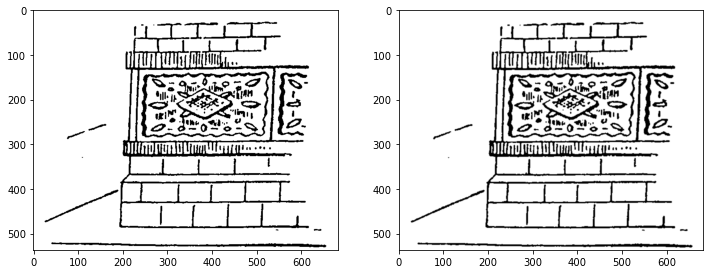

In [203]:

ind='119-2'
tttt = cv.imread(dealed_path+str(ind)+'.png', cv.IMREAD_COLOR) 
gray = cv.cvtColor(tttt.copy(), cv.COLOR_BGR2GRAY)

origin_size = (gray.shape[1],gray.shape[0])

gray =cv.resize(gray, (int(origin_size[0]*20),int(origin_size[1]*20)),interpolation=cv.INTER_NEAREST) 

tmp2 = cv.blur(gray,(21, 21))

# kernel = np.array([[-0, -1, -0],
#                    [-1,  5, -1],
#                    [-0, -1, -0]])
kernel = np.array([[-1, -1, -1],
                   [-1,  9, -1],
                   [-1, -1, -1]])

tmp2 = cv.filter2D(tmp2, -1, kernel)
tmp2 = cv.resize(tmp2, origin_size,interpolation=cv.INTER_NEAREST) 
tmp2 = cv.cvtColor(tmp2, cv.COLOR_GRAY2BGR)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(tttt)
plt.subplot(122)
plt.imshow(tmp2)

In [154]:
gray.shape

(439, 377)